In [1]:

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd, jacrev

from tqdm.notebook import tqdm
from math import sqrt
import matplotlib.pyplot as plt

import numpy as np
import warnings
warnings.filterwarnings("error")

In [2]:
# Network parameters
agent_num = 4
d = 100


data_num = 20
# Parameters for functions
a = np.random.randn(agent_num, data_num , d )/10
b = np.random.randn(agent_num , data_num )/10
center_shift = 0.1
half_data = int(data_num/2)
a[:,:half_data,:] +=center_shift
b[:,:half_data] =1

a[:,half_data:,:] -=center_shift
b[:,half_data:] =-1

# b[b >= 0] = 1
# b[b < 0] = -1

# print(-np.sum(b[:-2,:], axis=0))
# print(b[:-1,:])
# print(a)
# print(b)
# print(np.sum(b, axis=0))

In [3]:
averaging_matrix = np.ones((agent_num, agent_num))/agent_num

mix_weight = 0.1
mixing_matrix = np.eye(agent_num) *(1 - 2*mix_weight)
for i in range(agent_num):
    mixing_matrix[i,(i+1)%agent_num] = mixing_matrix[i,(i-1)%agent_num] = mix_weight
# print(mixing_matrix)


In [4]:
def global_function_logistic(x, a, b):
    agent_num = a.shape[0]
    data_num = a.shape[1]
    function_val= 0
    for i in range(agent_num):
        ax = jnp.dot(a[i,:],x)
        log_val = jnp.log(1 + jnp.exp(-b[i,:]*ax))
        function_val+= jnp.sum(log_val)/data_num
    return function_val/agent_num
            
def function_gradient_logistic_dist(x, a, b):
    
    agent_num = a.shape[0]
    data_num = a.shape[1]    

    gradient = np.zeros(x.shape)
    for i in range(agent_num):
        ax = a[i,:]@x[i]
        exp_val = np.exp(-b[i,:]*ax)
        temp_grad = exp_val/(1+exp_val)*(-b[i])
        # temp_grad = exp_val/(1+exp_val)
        # print(temp_grad.shape)
        for j in range(data_num):
            gradient[i] += temp_grad[j]*a[i,j]
        gradient[i] = gradient[i]/data_num
    return gradient

In [5]:
def centralized_function_logistic(x, a, b):
    agent_num = a.shape[0]
    data_num = a.shape[1]
    function_val= 0
    for i in range(agent_num):
        ax = jnp.dot(a[i,:],x)
        log_val = jnp.log(1 + jnp.exp(-b[i,:]*ax))
        function_val+= jnp.sum(log_val)/data_num
    return function_val/agent_num
            
def centralized_gradient_logistic(x, a, b):
    agent_num = a.shape[0]
    data_num = a.shape[1]    

    gradient = np.zeros(x.shape)
    for i in range(agent_num):
        ax = a[i,:]@x
        exp_val = np.exp(-b[i,:]*ax)
        temp_grad = exp_val/(1+exp_val)*(-b[i])
        # temp_grad = exp_val/(1+exp_val)
        # print(temp_grad.shape)
        for j in range(data_num):
            gradient += temp_grad[j]*a[i,j]
    gradient = gradient/(data_num*agent_num)
    return gradient

def centralized_hessian_logistic(x, a, b):
    agent_num = a.shape[0]
    data_num = a.shape[1]    

    hessian = np.zeros((x.shape[0],x.shape[0]))
    for i in range(agent_num):
        ax = a[i,:]@x
        exp_val = np.exp(-b[i,:]*ax)
        # print(exp_val.shape)
        temp_hess = (b[i]**2)*exp_val/(1+exp_val)**2
        for j in range(data_num):
            hessian += temp_hess[j]*np.outer(a[i,j],a[i,j])
    hessian = hessian/(data_num*agent_num)
    # print(hessian.shape)
    return hessian

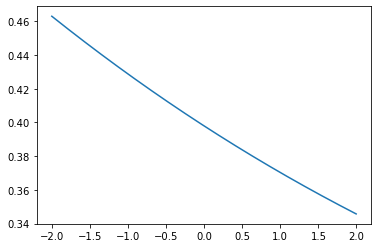

In [6]:
# See if the function is correct

x_base = np.linspace(-2,2,1000, endpoint=False)
func_val = np.zeros((1000))
x_real = np.random.randn(d)
for i in range(1000):
    x_real[3] = x_base[i]
    func_val[i] = centralized_function_logistic(x_real, a, b)

plt.plot(x_base, func_val)

In [9]:
x_star = np.zeros(d)
loss_star = centralized_function_logistic(x_star, a, b)
print(loss_star)


x_init = np.zeros(d)
iter_num = 100000
lr = 0.1

xk = np.zeros(d)
xk1 =  np.zeros(d)
GD_loss_x = np.zeros((iter_num))

for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    xk1 = xk - lr*gradient
    xk = np.copy(xk1)
    GD_loss_x[k] = centralized_function_logistic(xk-10, a,b)
# loss_star = 0

0.6931473


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
x_star = xk
print(x_star)
loss_star = np.min(GD_loss_x)
print(loss_star)

[ 9.33799573 10.23852568  8.88719253 10.00336253 11.13052277  9.02533811
 11.0602041  11.92315929 11.24503307 10.74530529  8.79700662 10.41602681
 11.51907773  9.07093062 10.39602027  9.35842342 10.3307311  10.88265873
  9.34226393 10.71097217 10.99517678 11.2108697   9.58037636  8.59439156
  9.24336241 10.09098333 11.65770077 10.57735281 10.69988365 10.59899403
  9.85128731 10.32176699 10.06675834  8.58079925 13.46106584 10.06485623
 10.94200172 10.7446571  10.5253905  11.22691093 10.09879812  9.74879534
  9.72016177  9.18875999  9.8414899   9.59558977 11.15217533 11.54787983
 10.90839807  9.38422524 11.14398835  7.31918202 12.23646434 10.41101273
 10.84161528 12.25030235 10.11328837 11.52762859  8.95855942 10.86458072
 10.5826022   9.47061159 10.41315798 12.01500094 11.12350927 10.75801455
 12.20725489 10.49024192 10.61778568  9.3904824  10.7585435  10.20666827
 10.8454247  10.40793644 10.65127068 10.72815154  9.70141478 11.55726455
 12.63776925  9.45793703 11.23172438 11.19706429 12

In [11]:
derivative_fn = grad(centralized_function_logistic)
# print(derivative_fn(x_star-10, a,b))




Hessian_fn = jacfwd(jacrev(centralized_function_logistic, argnums=0), argnums=0)

# hessian_j = Hessian_fn(x_star-10, a,b)
# print(hessian_j)

hessian_x = centralized_hessian_logistic(x_star-10, a,b)
print(hessian_x)

# x_0 = np.zeros((agent_num, d))
# print(np.mean(function_gradient_logistic_dist(x_0, a, b), axis=0))

[[3.65649941e-05 1.43905217e-05 1.65775904e-05 ... 2.00113295e-05
  2.19270055e-05 1.17211839e-05]
 [1.43905217e-05 2.48075469e-05 1.42965012e-05 ... 1.14582863e-05
  1.57550379e-05 1.44848648e-05]
 [1.65775904e-05 1.42965012e-05 3.64902773e-05 ... 2.41294957e-05
  1.38721124e-05 1.85563503e-05]
 ...
 [2.00113295e-05 1.14582863e-05 2.41294957e-05 ... 3.40682397e-05
  1.69393098e-05 1.34347168e-05]
 [2.19270055e-05 1.57550379e-05 1.38721124e-05 ... 1.69393098e-05
  3.12201937e-05 1.33562599e-05]
 [1.17211839e-05 1.44848648e-05 1.85563503e-05 ... 1.34347168e-05
  1.33562599e-05 2.44819980e-05]]


In [12]:
# Centralized GD
x_init = np.ones(d)*10
iter_num = 10000
lr = 0.1

xk = np.ones(d)*10
xk1 =  np.ones(d)*10
GD_loss_x = np.zeros((iter_num))

for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    xk1 = xk - lr*gradient
    xk = np.copy(xk1)
    GD_loss_x[k] = centralized_function_logistic(xk-10, a,b)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [164]:
# print(np.min(xk1))

In [13]:
# Centralized MD
x_init = np.ones(d)*10
iter_num = 10000
lr = 0.1

xk = np.ones(d)*10
xk1 =  np.ones(d)*10
zk =  np.ones(d)*10
zk1 =  np.ones(d)*10
MD_loss_x = np.zeros((iter_num))

for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    zk = np.log(np.maximum(xk,1e-10))+1
#to make sure x is greater or equal to 0+
    zk1 = zk - lr*gradient
    # print(np.max(zk1))
    xk1 = np.exp(zk1)/np.exp(1)
    xk = np.copy(xk1)
    zk = np.copy(xk1)
    MD_loss_x[k] = centralized_function_logistic(xk-10, a,b)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [98]:
# print(MD_loss_x)

In [14]:
# Centralized QR Newton

x_init = np.ones(d)*10
iter_num = 10000
lr = 0.1

xk = np.ones(d)*10
xk1 =  np.ones(d)*10
QR_loss_x = np.zeros((iter_num))

for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    hessian_x = centralized_hessian_logistic(xk-10, a,b)
    
    # gradient = derivative_fn(xk-10, a,b)
    # hessian_x = Hessian_fn(xk-10, a,b)
    
    
    A_k = np.sqrt((5)*np.linalg.norm(gradient))
    # print(A_k)
    # delta = np.array(np.linalg.inv(hessian_x+A_k*np.eye(d))@gradient)
    # delta = np.array(np.linalg.solve(hessian_x+A_k*np.eye(d), gradient))
    delta = np.array(np.linalg.lstsq(hessian_x+A_k*np.eye(d), gradient, rcond=None)[0])
    # delta[delta>1] = 1
    # delta[delta<-1] = -1
    
    xk1 = xk - delta
    xk = np.copy(xk1)
    QR_loss_x[k] = centralized_function_logistic(xk-10, a,b)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [390]:
# # Centralized CR Newton
# inner_iter = 10000
# x_init = np.ones(d)*10
# iter_num = 1000
# lr = 0.1

# xk = np.ones(d)*10
# xk1 =  np.ones(d)*10
# CR_loss_x = np.zeros((iter_num))

# for k in tqdm(range( iter_num)):
#     gradient = derivative_fn(xk-10, a,b)
#     hessian_x = Hessian_fn(xk-10, a,b)
    
#     direction = -np.linalg.inv(hessian_x)@gradient
#     first_order_term = gradient.T@direction
#     second_order_term = direction.T@hessian_x@direction
#     third_order_term = np.linalg.norm(direction)**3
#     # print(first_order_term)
#     # print(second_order_term)
#     # print(third_order_term)
#     # print()
#     alpha = 1
#     # we want best alpha such that minimizes a*first + a^2*second + a^3* third
#     for t in range(inner_iter):
#         alpha_grad = first_order_term + alpha*second_order_term + alpha*np.abs(alpha)*third_order_term
#         alpha = alpha - 0.0*alpha_grad
#         # print(alpha)
    
#     xk1 = xk + alpha*direction
#     xk = np.copy(xk1)
#     CR_loss_x[k] = global_function_logistic(xk-10, a,b)
#     print(alpha)
#     input()

In [15]:
# Centralized CR Newton
inner_iter = 100
x_init = np.ones(d)*10
iter_num = 10000
lr = 0.1
rho = 1
xk = np.ones(d)*10
xk1 =  np.ones(d)*10
CR_loss_x = np.zeros((iter_num))

for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    hessian_x = centralized_hessian_logistic(xk-10, a,b)
    
    xk1 = np.copy(xk)
    # we want best alpha such that minimizes a*first + a^2*second + a^3* third
    for t in range(inner_iter):
        x_grad = gradient + hessian_x@(xk1 - xk)+ 0.5*rho*np.linalg.norm(xk1 - xk)*(xk1 - xk)
        # print(np.mean(x_grad))
        xk1 = xk1 - lr*x_grad
        # print(alpha)
    
    xk = np.copy(xk1)
    CR_loss_x[k] = centralized_function_logistic(xk-10, a,b)
    # print(np.linalg.norm(x_grad))
    # input()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
# Centralized Bregman Newton
inner_iter = 10000
x_init = np.ones(d)*10
iter_num = 10000
lr = 0.1

xk = np.ones(d)*10
xk1 =  np.ones(d)*10
BR_loss_x = np.zeros((iter_num))
Ak = 0
for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    hessian_x = centralized_hessian_logistic(xk-10, a,b)
    z_xk = np.log(np.maximum(xk,1e-10))+1
    y_opt = np.copy(xk)
    z_y = np.log(np.maximum(y_opt,1e-10))+1
    # we use gd to find it
    for t in range(inner_iter):
        
        y_grad = gradient+ hessian_x@(y_opt-xk) + Ak*(z_y - z_xk)
        y_opt = y_opt - 0.1*y_grad
        z_y = np.log(np.maximum(y_opt,1e-10))+1
    
    xk1 = y_opt
    z_y = np.log(np.maximum(y_opt,1e-10))+1
    gradient_new = centralized_gradient_logistic(xk1-10, a,b)
    gk = np.linalg.norm(gradient_new - gradient - hessian_x@(y_opt-xk) - Ak*(z_y - z_xk))
    Ak = 1*np.sqrt(5*gk)
    xk = np.copy(xk1)
    BR_loss_x[k] = centralized_function_logistic(xk-10, a,b)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
# Centralized Bregman Newton for another bregman choice, Burg's entropy
inner_iter = 1000
x_init = np.ones(d)*10
iter_num = 1000
lr = 0.1

xk = np.ones(d)*10
xk1 =  np.ones(d)*10
BR_BE_loss_x = np.zeros((iter_num))
Ak = 0
for k in tqdm(range( iter_num)):
    gradient = centralized_gradient_logistic(xk-10, a,b)
    hessian_x = centralized_hessian_logistic(xk-10, a,b)
    z_xk = -1/np.maximum(xk,1e-30)
    y_opt = np.copy(xk)
    z_y = -1/np.maximum(y_opt,1e-30)
    # we use gd to find it
    for t in range(inner_iter):
        
        y_grad = gradient+ hessian_x@(y_opt-xk) + Ak*(z_y - z_xk)
        y_opt = y_opt - 0.1*y_grad
        z_y = -1/np.maximum(y_opt,1e-30)
        # print(y_grad)
        # print(z_y)
        # input()
    xk1 = y_opt
    z_y = -1/np.maximum(y_opt,1e-30)
    gradient_new = centralized_gradient_logistic(xk1-10, a,b)
    gk = np.linalg.norm(gradient_new - gradient - hessian_x@(y_opt-xk) - Ak*(z_y - z_xk))
    Ak = 1*np.sqrt(5*gk)
    xk = np.copy(xk1)
    BR_BE_loss_x[k] = centralized_function_logistic(xk-10, a,b)
    # print()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
# # Centralized QR Newton with acceleration

# x_init = np.ones(d)*10
# iter_num = 10000
# lr = 0.1
# L_f = 15
# xk = np.ones(d)*10
# xk1 =  np.ones(d)*10
# QR_Accel_loss_x = np.zeros((iter_num))
# B_k = 0
# b_k1 = 0
# for k in tqdm(range( iter_num)):
#     gradient = centralized_gradient_logistic(xk-10, a,b)
#     hessian_x = centralized_hessian_logistic(xk-10, a,b)
#     b_k1 = (k+1)**2/(9*L_f)
#     B_k1 = B_k+b_k1
#     A_k = np.sqrt((L_f/3)*np.linalg.norm(gradient))
#     # print(A_k)
#     gradient = gradient*B_k1
#     hessian_x = hessian_x*B_k1
#     delta = np.array(np.linalg.inv(hessian_x+A_k*np.eye(d))@gradient)
#     # delta[delta>1] = 1
#     # delta[delta<-1] = -1
    
#     xk1 = xk - delta
#     xk = np.copy(xk1)
#     # xk = (b_k1*xk1+B_k*xk)/B_k1
#     B_k = B_k1
#     QR_Accel_loss_x[k] = global_function_logistic(xk-10, a,b)
    

In [24]:
# # Centralized Bregman Newton accelerated
# inner_iter = 100
# x_init = np.ones(d)*10
# iter_num = 10000
# lr = 0.1
# vk = np.ones(d)*10

# xk = np.ones(d)*10
# xk1 =  np.ones(d)*10
# BR_Accel_loss_x = np.zeros((iter_num))
# Ak = 0
# B_k = 0
# b_k1 = 0
# for k in tqdm(range( iter_num)):
#     b_k1 = (k+1)**2/(9*L_f)
#     B_k1 = B_k+b_k1
#     gradient = centralized_gradient_logistic(xk-10, a,b)
#     hessian_x = centralized_hessian_logistic(xk-10, a,b)
#     gradient = gradient*B_k1
#     hessian_x = hessian_x*B_k1
#     z_xk = np.log(np.maximum(xk,1e-10))+1
#     y_opt = np.copy(xk)
#     z_y = np.log(np.maximum(y_opt,1e-10))+1
#     # we use gd to find it
#     for t in range(inner_iter):
        
#         y_grad = gradient+ hessian_x@(y_opt-xk) + Ak*(z_y - z_xk)
#         z_y = z_y - 0.1*y_grad
#         y_opt = np.exp(z_y)/np.exp(1)
    
#     xk1 = y_opt
#     vk = (B_k1 *xk1 - B_k*xk)/b_k1
#     z_y = np.log(np.maximum(xk1,1e-10))+1
#     gradient_new = centralized_gradient_logistic(vk-10, a,b)
#     gk = np.linalg.norm(b_k1*gradient_new - gradient - hessian_x@(y_opt-xk) - Ak*(z_y - z_xk))
#     Ak = 1*np.sqrt(5*gk)
#     xk = np.copy(xk1)
#     BR_Accel_loss_x[k] = global_function_logistic(xk-10, a,b)

In [18]:
# def distributed_function_logistic(x, a, b):
#     agent_num = a.shape[0]
#     data_num = a.shape[1]
#     function_val= 0
#     for i in range(agent_num):
#         ax = jnp.dot(a[i,:],x)
#         log_val = jnp.log(1 + jnp.exp(-b[i,:]*ax))
#         function_val+= jnp.sum(log_val)/data_num
#     return function_val/agent_num
            
def distributed_gradient_logistic(x, a, b):
    agent_num = a.shape[0]
    data_num = a.shape[1]    

    gradient = np.zeros(x.shape)
    if x.shape[0]!=agent_num or x.shape[1]!=a.shape[2]:
        print("dismension mismatched")
    for i in range(agent_num):
        ax = a[i,:]@x[i]
        exp_val = np.exp(-b[i,:]*ax)
        temp_grad = exp_val/(1+exp_val)*(-b[i])
        # temp_grad = exp_val/(1+exp_val)
        # print(temp_grad.shape)
        for j in range(data_num):
            gradient[i] += temp_grad[j]*a[i,j]
    gradient = gradient/(data_num)
    return gradient

def distributed_hessian_logistic(x, a, b):
    agent_num = a.shape[0]
    data_num = a.shape[1]    
    if x.shape[0]!=agent_num or x.shape[1]!=a.shape[2]:
        print("dismension mismatched")
    hessian = np.zeros((agent_num, x.shape[1],x.shape[1]))
    for i in range(agent_num):
        ax = a[i,:]@x[i]
        exp_val = np.exp(-b[i,:]*ax)
        # print(exp_val.shape)
        temp_hess = (b[i]**2)*exp_val/(1+exp_val)**2
        # print(temp_hess.shape)
        for j in range(data_num):
            hessian[i] += temp_hess[j]*np.outer(a[i,j],a[i,j])
    hessian = hessian/(data_num)
    # print(hessian.shape)
    return hessian

In [ ]:
# Decentralized Bregman Regularized Newton
inner_iter = 10000

iter_num = 10000
lr = 0.1

xk = np.ones((agent_num, d))*10
xk1 =  np.ones((agent_num, d))*10

yk = np.zeros((agent_num, d))*10
yk1 =  np.zeros((agent_num, d))*10

BR_loss_x_dist = np.zeros((iter_num, agent_num))
Ak = np.zeros((agent_num))
gk = np.zeros((agent_num))
vk1 = np.ones((agent_num, d))*10


for k in tqdm(range( iter_num)):
    gradient = distributed_gradient_logistic(xk-10, a,b)
    hessian_x = distributed_hessian_logistic(xk-10, a,b)
    
    z_xk = np.log(np.maximum(xk,1e-10))+1
    x_iter = np.copy(xk)
    z_iter = np.log(np.maximum(x_iter,1e-10))+1
    for i in range(agent_num):
        for t in range(inner_iter):
            x_grad = gradient[i]+ hessian_x[i]@(x_iter[i]-xk[i]) + Ak[i]*(z_iter[i] - z_xk[i])
            x_iter[i] = x_iter[i] - 0.1*x_grad
            # x_iter[i] = np.exp(z_iter[i])/np.exp(1)
            z_iter = np.log(np.maximum(x_iter,1e-10))+1
    vk1 = np.copy(x_iter)
    gradient_new = distributed_gradient_logistic(vk1-10, a,b)
    for i in range(agent_num):
        gk[i] = np.linalg.norm(gradient_new[i] - gradient[i] - hessian_x[i]@(x_iter[i]-xk[i]) - Ak[i]*(z_iter[i] - z_xk[i]))
        Ak[i] = 1*np.sqrt(5*gk[i])
        
        # yk1[i,:] = yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        # A_k[i] = np.sqrt((5)*np.linalg.norm(gradient[i,:]))
    # print(A_k)
        # delta = np.array(np.linalg.inv(hessian_x[i]+A_k[i]*np.eye(d))@gradient[i])
        # vk1[i] = xk[i] - delta
    # delta[delta>1] = 1
    # delta[delta<-1] = -1
    for i in range(agent_num):
        yk1[i,:] = yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        xk1[i] = vk1[i] + yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        # xk1[i] = vk1[i] + yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        BR_loss_x_dist[k,i] = centralized_function_logistic(xk[i]-10, a,b)
        
    
    xk = np.copy(xk1)
    yk = np.copy(yk1)
    # print(yk)
    
    
    
    # we use gd to find it
    
    
    
#     z_y = np.log(np.maximum(y_opt,1e-10))+1
    
#     gk = np.linalg.norm(gradient_new - gradient - hessian_x@(y_opt-xk) - Ak*(z_y - z_xk))
#     Ak = 1*np.sqrt(5*gk)
#     xk = np.copy(xk1)
#     BR_loss_x[k] = centralized_function_logistic(xk-10, a,b)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Decentralized Bregman Regularized Newton multiple communication
inner_iter = 10000

iter_num = 10000
lr = 0.1

xk = np.ones((agent_num, d))*10
xk1 =  np.ones((agent_num, d))*10

yk = np.zeros((agent_num, d))*10
yk1 =  np.zeros((agent_num, d))*10

BR_loss_x_MC = np.zeros((iter_num, agent_num))
Ak = np.zeros((agent_num))
gk = np.zeros((agent_num))


for k in tqdm(range( iter_num)):
    gradient = distributed_gradient_logistic(xk-10, a,b)
    hessian_x = distributed_hessian_logistic(xk-10, a,b)
    z_xk = np.log(np.maximum(xk,1e-10))+1
    x_iter = np.copy(xk)
    z_iter = np.log(np.maximum(x_iter,1e-10))+1
    for t in range(inner_iter):
        for i in range(agent_num):
            x_grad = gradient[i]+ hessian_x[i]@(x_iter[i]-xk[i]) + Ak[i]*(z_iter[i] - z_xk[i])
            x_iter[i] = x_iter[i] - 0.1*x_grad
        x_temp = np.copy(x_iter)
        for i in range(agent_num):
            x_iter[i] = x_temp[i] + 0.1*(x_temp[(i+1)%agent_num,:]+x_temp[(i-1)%agent_num,:] - 2*x_temp[i,:])
        z_iter = np.log(np.maximum(x_iter,1e-10))+1
    xk1 = np.copy(x_iter)
    gradient_new = distributed_gradient_logistic(vk1-10, a,b)
    for i in range(agent_num):
        gk[i] = np.linalg.norm(gradient_new[i] - gradient[i] - hessian_x[i]@(x_iter[i]-xk[i]) - Ak[i]*(z_iter[i] - z_xk[i]))
        Ak[i] = 1*np.sqrt(5*gk[i])
        BR_loss_x_MC[k,i] = centralized_function_logistic(xk[i]-10, a,b)
        
    xk = np.copy(xk1)
    yk = np.copy(yk1)


In [21]:
# Decentralized Quadratic Newton

iter_num = 1000
lr = 0.1

xk = np.ones((agent_num, d))*10
xk1 =  np.ones((agent_num, d))*10

yk = np.zeros((agent_num, d))*10
yk1 =  np.zeros((agent_num, d))*10

QR_loss_x_dist = np.zeros((iter_num, agent_num))
A_k = np.zeros((agent_num))*10
vk1 = np.ones((agent_num, d))*10

for k in tqdm(range( iter_num)):
    gradient = distributed_gradient_logistic(xk-10, a,b)
    hessian_x = distributed_hessian_logistic(xk-10, a,b)
    
    
    for i in range(agent_num):
        yk1[i,:] = yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        A_k[i] = np.sqrt((5)*np.linalg.norm(gradient[i,:]))
    # print(A_k)
        delta = np.array(np.linalg.inv(hessian_x[i]+A_k[i]*np.eye(d))@gradient[i])
        vk1[i] = xk[i] - delta
    # delta[delta>1] = 1
    # delta[delta<-1] = -1
    for i in range(agent_num):
        xk1[i] = vk1[i] + yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        # xk1[i] = vk1[i] + yk[i,:] + 0.1*(xk[(i+1)%agent_num,:]+xk[(i-1)%agent_num,:] - 2*xk[i,:])
        QR_loss_x_dist[k,i] = centralized_function_logistic(xk[i]-10, a,b)

    xk = np.copy(xk1)
    yk = np.copy(yk1)
    # print(yk)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
iter_num = 10000
k_range = np.linspace(0,iter_num, iter_num)
print(k_range.shape)

loss_star = np.minimum(np.min(BR_loss_x), np.min(QR_loss_x))
loss_star = np.minimum(np.min(loss_star), np.min(BR_BE_loss_x))
loss_star = np.minimum(np.min(loss_star), np.min(CR_loss_x))
# loss_star = np.minimum(np.min(loss_star), np.min(QR_Accel_loss_x))

# plt.plot((k_range+1)**2*(GD_loss_x[:iter_num]-loss_star), label="gradient")
# plt.plot((k_range+1)**2*(MD_loss_x[:iter_num]-loss_star), label="mirror")
# plt.plot((k_range+1)**2*(CR_loss_x[:iter_num]-loss_star), label="cubic")
plt.plot((k_range+1)**2*(QR_loss_x[:iter_num]-loss_star), label="quadratic")
plt.plot((k_range+1)**2*(BR_loss_x[:iter_num]-loss_star), label="bregman")
# plt.plot((k_range+1)**2*(BR_BE_loss_x[:iter_num]-loss_star), label="burg entropy")
plt.plot((k_range+1)**2*(QR_loss_x_dist[:iter_num,0]-loss_star), label="quadratic distributed agent 0")
# plt.plot((k_range+1)**2*(QR_loss_x_dist[:,1]-loss_star), label="quadratic distributed agent 1")
plt.plot((k_range+1)**2*(BR_loss_x_dist[:iter_num,0]-loss_star), label="Bregman distributed agent 0")
# plt.plot((k_range+1)**2*(BR_loss_x_dist[:,1]-loss_star), label="Bregman distributed agent 1")
plt.plot((k_range+1)**2*(BR_loss_x_MC[:iter_num,0]-loss_star), label="Bregman distributed agent 0 with multi communications")
# plt.plot((k_range+1)**2*(BR_loss_x_MC[:,1]-loss_star), label="Bregman distributed agent 1 with multi communications")

plt.legend()
# plt.ylim(0, 60)
plt.ylim(0, 2)
# plt.xlim(0,100)
plt.ylabel("(f - f*)k^2")
plt.xlabel("iteration number")

# plt.savefig("100d_k2_distributed")

In [243]:
# #start the algorithm, this block is normal dgd
# x_0 = np.random.rand(agent_num, d)

# #first is gradient Descent
# iter_num = 100000
# lr = 0.1
# time_int = 0.01

# x_k = np.zeros((agent_num,d))
# x_k1 = np.zeros((agent_num,d))

# z_k = np.zeros((agent_num,d))
# z_k1 = np.zeros((agent_num,d))
# # x_k2 = np.zeros((agent_num,d))
# y_k = np.zeros((agent_num,d))
# y_k1 = np.zeros((agent_num,d))

# DGD_x_mean = np.zeros((iter_num,d))

# DGD_x_dist = np.zeros((iter_num, agent_num))

# DGD_loss_x_global = np.zeros((iter_num, agent_num))

# lambda_0 = 0
# lambda_k = 0
# lambda_k1 = 0

# # simulation centralized
# for agent in range(agent_num):
#     x_k[agent,:] = np.mean(x_0, axis=0)
# #

# # x_k = np.copy(x_0)
# z_k =  np.copy(x_k)

# lambda_k = lambda_0
# for k in tqdm(range( iter_num)):
#     lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
#     gamma = (1-lambda_k)/(lambda_k1)
#     lambda_k = lambda_k1
#     gradient_all = function_gradient_case_3(x_k, a, b) 
    
#     gradient_avg =  np.mean(gradient_all, axis=0)
#     for i in range(agent_num):
#         y_k1[i,:] = y_k[i,:] + time_int*(x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:])
#         z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_avg - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
#         x_k1[i,:] = z_k1[i,:]
#         # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:]
#     z_k = np.copy(z_k1)
#     x_k = np.copy(x_k1)
#     y_k = np.copy(y_k1)
    
#     x_bar = np.mean(x_k, axis=0)
    
#     DGD_x_mean[k,:] = x_bar
#     for agent in range(agent_num):
        
#         DGD_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
#         DGD_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
    
    

In [334]:
#start the algorithm
x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.1
s = time_int
sqrt_s = np.sqrt(s)

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

x_mean = np.zeros((iter_num,d))
x_dist = np.zeros((iter_num, agent_num))
loss_x_global = np.zeros((iter_num, agent_num))

lambda_0 = 0
lambda_k = 0
lambda_k1 = 0

x_k = np.copy(x_0)
z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    gamma = (1-lambda_k)/(lambda_k1)
    lambda_k = lambda_k1
    gradient_all = function_gradient_case_3(x_k, a, b)
    # gradient_all = np.zeros(z_k.shape)
    for i in range(agent_num):
        y_k1[i,:] = y_k[i,:] + s*(1/agent_num)*(2*z_k[i,:]-z_k[(i+1)%agent_num,:]-z_k[(i-1)%agent_num,:] )
        # z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] ))
        z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ 10*(1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]-z_k[(i-1)%agent_num,:] ))
        # x_k1[i,:] = z_k1[i,:]
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:] #-  time_int*(0- (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]) )
        z_diff = z_k1 - z_k
        x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) -  10*sqrt_s*(1/agent_num)*( 2*z_diff[i,:]-z_diff[(i-1)%agent_num,:] -z_diff[(i+1)%agent_num,:] ) #z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) 
        
        # z_bar = np.mean(z_k, axis=0)
        # z1_bar = np.mean(z_k1, axis=0)
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] -gamma*(z_k1[i,:] - z_k[i,:]) +  time_int*( (z_k1[(i-1)%agent_num,:] - z_k[(i-1)%agent_num,:]+z_k1[(i+1)%agent_num,:] - z_k[(i+1)%agent_num,:] - 2*(z_k1[i,:] - z_k[i,:])) )
    z_k = np.copy(z_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    
    x_bar = np.mean(x_k, axis=0)
    x_mean[k,:] = x_bar
    for agent in range(agent_num):
        x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [442]:
#testing



x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01
s = time_int
sqrt_s = np.sqrt(s)

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

w_k = np.zeros((agent_num,d))
w_k1 = np.zeros((agent_num,d))

x_mean = np.zeros((iter_num,d))
x_dist = np.zeros((iter_num, agent_num))
loss_x_global = np.zeros((iter_num, agent_num))

lambda_0 = 0
lambda_k = 0
lambda_k1 = 0

x_k = np.copy(x_0)
z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    gamma = (1-lambda_k)/(lambda_k1)
    lambda_k = lambda_k1
    gradient_all = function_gradient_case_3(x_k, a, b)
    
    # gradient_all = averaging_matrix@gradient_all
    # gradient_all = np.zeros(z_k.shape)
    for i in range(agent_num):
        y_k1[i,:] = y_k[i,:] + s*(1/agent_num)*(2*x_k[i,:]-x_k[(i+1)%agent_num,:]-x_k[(i-1)%agent_num,:] )
        # z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] ))
    # y_k1 = averaging_matrix@y_k1
    for i in range(agent_num):
        z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ 10*(1/agent_num)*(2*x_k[i,:] - x_k[(i+1)%agent_num,:]-x_k[(i-1)%agent_num,:] ))
        # x_k1[i,:] = z_k1[i,:]
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:] #-  time_int*(0- (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]) )
    for i in range(agent_num):

        z_diff = z_k1 - z_k
        w_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) -  10*sqrt_s*(1/agent_num)*( 2*z_diff[i,:]-z_diff[(i-1)%agent_num,:] -z_diff[(i+1)%agent_num,:] ) #z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) 
        
        
    for i in range(agent_num):
        x_k1[i,:] = w_k1[i,:] #- s* (2*w_k1[i,:]-w_k1[(i+1)%agent_num,:]-w_k1[(i-1)%agent_num,:])
    # x_k1 = mixing_matrix@x_k1
        # z_bar = np.mean(z_k, axis=0)
        # z1_bar = np.mean(z_k1, axis=0)
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] -gamma*(z_k1[i,:] - z_k[i,:]) +  time_int*( (z_k1[(i-1)%agent_num,:] - z_k[(i-1)%agent_num,:]+z_k1[(i+1)%agent_num,:] - z_k[(i+1)%agent_num,:] - 2*(z_k1[i,:] - z_k[i,:])) )
    z_k = np.copy(z_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    w_k = np.copy(w_k1)
    
    
    
    
    x_bar = np.mean(x_k, axis=0)
    x_mean[k,:] = x_bar
    for agent in range(agent_num):
        x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [474]:
#inplementing na li's formulation



x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01
s = time_int
sqrt_s = np.sqrt(s)

eta_t = 0.01

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

v_k = np.zeros((agent_num,d))
v_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

s_k = np.zeros((agent_num,d))
s_k1 = np.zeros((agent_num,d))

na_x_mean = np.zeros((iter_num,d))
na_x_dist = np.zeros((iter_num, agent_num))
na_loss_x_global = np.zeros((iter_num, agent_num))

alpha_0 = 0.5
alpha_k = alpha_0
alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

s_k = function_gradient_case_3(x_k, a, b)

# x_k = np.copy(x_0)
# z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

    # lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    # gamma = (1-lambda_k)/(lambda_k1)
    # lambda_k = lambda_k1
    
    
    x_k1 = mixing_matrix@y_k - eta_t*s_k
    v_k1 = mixing_matrix@v_k - eta_t/alpha_k*s_k
    y_k1 = (1 - alpha_k1)*x_k1 + alpha_k1 * v_k1
    
    gradient_last = function_gradient_case_3(y_k, a, b)
    gradient_new = function_gradient_case_3(y_k1, a, b)
    
    s_k1 = mixing_matrix@s_k + (gradient_new - gradient_last)


    s_k = np.copy(s_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    v_k = np.copy(v_k1)
    alpha_k = alpha_k1
    
    
    
    x_bar = np.mean(x_k, axis=0)
    na_x_mean[k,:] = x_bar
    for agent in range(agent_num):
        na_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        na_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [475]:
#inplementing Lin & Li's formulation



x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01
s = time_int
sqrt_s = np.sqrt(s)

eta_t = 0.01

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

s_k = np.zeros((agent_num,d))
s_k1 = np.zeros((agent_num,d))

lin_x_mean = np.zeros((iter_num,d))
lin_x_dist = np.zeros((iter_num, agent_num))
lin_loss_x_global = np.zeros((iter_num, agent_num))

alpha_0 = 0.5
alpha_k = alpha_0
alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

s_k = function_gradient_case_3(x_k, a, b)

# x_k = np.copy(x_0)
# z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

    # lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    # gamma = (1-lambda_k)/(lambda_k1)
    # lambda_k = lambda_k1
    
    y_k1 = alpha_k* z_k + (1 - alpha_k)*x_k
    
    gradient_last = function_gradient_case_3(y_k, a, b)
    gradient_new = function_gradient_case_3(y_k1, a, b)    
    
    s_k1 = mixing_matrix@s_k + (gradient_new - gradient_last)
    z_k1 = mixing_matrix@z_k - (eta_t/alpha_k)*s_k1
    x_k1 = alpha_k * z_k1 + (1 - alpha_k)*mixing_matrix@x_k
    
#     x_k1 = mixing_matrix@y_k - eta_t*s_k
#     v_k1 = mixing_matrix@v_k - eta_t/alpha_k*s_k
#     y_k1 = (1 - alpha_k1)*x_k1 + alpha_k1 * v_k1
    
    alpha_k = alpha_k1
    
#     s_k1 = mixing_matrix@s_k + (gradient_new - gradient_last)


    s_k = np.copy(s_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    z_k = np.copy(z_k1)
    
    
    
    
    x_bar = np.mean(x_k, axis=0)
    lin_x_mean[k,:] = x_bar
    for agent in range(agent_num):
        lin_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        lin_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [476]:
# print(10*sqrt_s*(1/agent_num)*( 2*z_diff[i,:]-z_diff[(i-1)%agent_num,:] -z_diff[(i+1)%agent_num,:] ) )
# print((1 - (3/(k+1)) )*(z_diff[i,:]))

# print(s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] )))
# print(s*(   (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] )))
# # print(s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] )))




(0.0, 100.0)

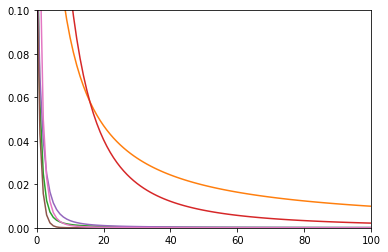

In [178]:
plt.plot((GD_loss_x-loss_star))
plt.plot((MD_loss_x-loss_star))
plt.plot((CR_loss_x-loss_star))
plt.plot((QR_loss_x-loss_star))
plt.plot((BR_loss_x-loss_star))
plt.plot((BR_BE_loss_x-loss_star))
plt.plot((BR_loss_x_MC[:,0]-loss_star), label="Bregman distributed agent 0 with multi communications")

# plt.plot((QR_Accel_loss_x-loss_star))
# plt.plot(np.linalg.norm(na_x_mean+2, axis = 1))
# plt.plot(np.linalg.norm(lin_x_mean+2, axis = 1))
# plt.plot(np.linalg.norm(DGD_x_mean+2, axis = 1))
plt.ylim(0, 0.1)
plt.xlim(0,100)
# plt.savefig("100d")

(10000,)


ValueError: operands could not be broadcast together with shapes (10000,) (1000,) 

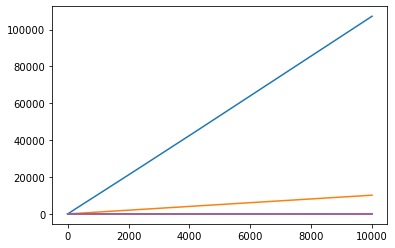

In [182]:
k_range = np.linspace(0,iter_num, iter_num)
print(k_range.shape)

plt.plot((k_range+1)**2*(GD_loss_x-loss_star), label="gradient")
plt.plot((k_range+1)**2*(MD_loss_x-loss_star), label="mirror")
plt.plot((k_range+1)**2*(CR_loss_x-loss_star), label="cubic")
plt.plot((k_range+1)**2*(QR_loss_x-loss_star), label="quadratic")
plt.plot((k_range+1)**2*(BR_loss_x-loss_star), label="bregman")
plt.plot((k_range+1)**2*(BR_BE_loss_x-loss_star), label="burg entropy")
# plt.plot((k_range+1)**2*(QR_Accel_loss_x-loss_star), label="quadratic accelerated")

plt.legend()
plt.ylim(0, 100)
plt.xlim(0,1000)
# plt.savefig("100d_k^2")

(10000,)


(0.0, 1000.0)

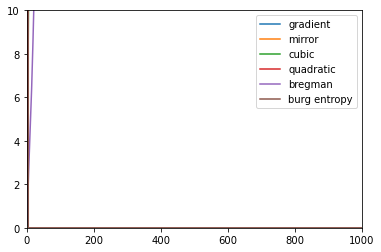

In [27]:
k_range = np.linspace(0,iter_num, iter_num)
print(k_range.shape)

plt.plot((k_range+1)**3*(GD_loss_x-loss_star), label="gradient")
plt.plot((k_range+1)**3*(MD_loss_x-loss_star), label="mirror")
plt.plot((k_range+1)**3*(CR_loss_x-loss_star), label="cubic")
plt.plot((k_range+1)**3*(QR_loss_x-loss_star), label="quadratic")
plt.plot((k_range+1)**3*(BR_loss_x-loss_star), label="bregman")
plt.plot((k_range+1)**3*(BR_BE_loss_x-loss_star), label="burg entropy")
# plt.plot((k_range+1)**3*(QR_Accel_loss_x-loss_star), label="quadratic accelerated")

plt.legend()
plt.ylim(0, 10)
plt.xlim(0,1000)
# plt.savefig("100d_k^2")

(10000,)


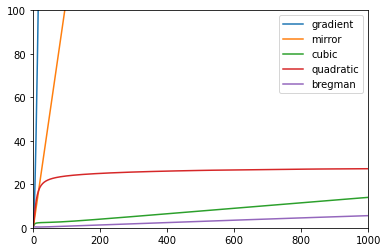

In [24]:
loss_star = np.minimum(np.min(BR_loss_x), np.min(QR_loss_x))
loss_star = np.minimum(np.min(loss_star), np.min(BR_BE_loss_x))
loss_star = np.minimum(np.min(loss_star), np.min(CR_loss_x))
# loss_star = np.minimum(np.min(loss_star), np.min(QR_Accel_loss_x))

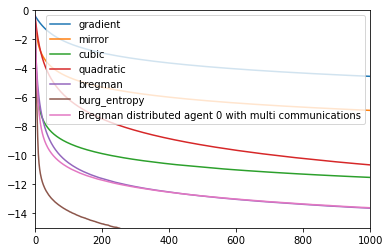

In [204]:
plt.plot(np.log(np.maximum(GD_loss_x-loss_star, 1e-30)), label="gradient")
plt.plot(np.log(np.maximum(MD_loss_x-loss_star, 1e-30)), label="mirror")
plt.plot(np.log(np.maximum(CR_loss_x-loss_star, 1e-30)), label="cubic")
plt.plot(np.log(np.maximum(QR_loss_x-loss_star, 1e-30)), label="quadratic")
plt.plot(np.log(np.maximum(BR_loss_x-loss_star, 1e-30)), label="bregman")
plt.plot(np.log(np.maximum(BR_BE_loss_x-loss_star, 1e-30)), label="burg_entropy")
plt.plot(np.log(np.maximum(BR_loss_x_MC[:,0]-loss_star, 1e-30)), label="Bregman distributed agent 0 with multi communications")

# plt.plot(np.log(np.maximum(QR_Accel_loss_x-loss_star, 1e-30)), label="quadratic accelerated")
# plt.plot(np.linalg.norm(na_x_mean+2, axis = 1))
# plt.plot(np.linalg.norm(lin_x_mean+2, axis = 1))
plt.ylim(-15, 0)
plt.xlim(0,1000)
plt.legend()
# plt.savefig("100d_log")

In [147]:
np.save("a_d1000.npy", a)
np.save("b_d1000.npy", b)
np.save("x_star_d1000.npy", x_star)
np.save("loss_star_d1000.npy", loss_star)
np.save("GD_d1000.npy", GD_loss_x)
np.save("MD_d1000.npy", MD_loss_x)
np.save("QR_d1000.npy", QR_loss_x)
np.save("CR_d1000.npy", CR_loss_x)
np.save("BR_d1000.npy", BR_loss_x)
# np.save("b_d4.npy", b)
# x_star


[inf nan nan ... nan nan nan]


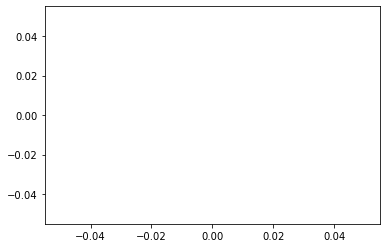

In [508]:
plt.plot(BR_loss_x)
# plt.ylim(0,1e-7)

print(BR_loss_x)

In [551]:
GD_time = 4200
MD_time = 4100
CR_time = 385
QR_time = 412
BR_time = 372
BR_BE_time = 381

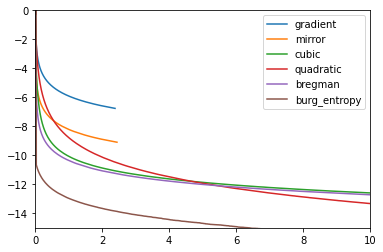

In [555]:
k_range = np.linspace(0,iter_num, iter_num)

plt.plot(k_range/GD_time, np.log(np.maximum(GD_loss_x-loss_star, 1e-30)), label="gradient")
plt.plot(k_range/MD_time, np.log(np.maximum(MD_loss_x-loss_star, 1e-30)), label="mirror")
plt.plot(k_range/CR_time, np.log(np.maximum(CR_loss_x-loss_star, 1e-30)), label="cubic")
plt.plot(k_range/QR_time, np.log(np.maximum(QR_loss_x-loss_star, 1e-30)), label="quadratic")
plt.plot(k_range/BR_time, np.log(np.maximum(BR_loss_x-loss_star, 1e-30)), label="bregman")
plt.plot(k_range/BR_BE_time, np.log(np.maximum(BR_BE_loss_x-loss_star, 1e-30)), label="burg_entropy")
# plt.plot(np.linalg.norm(na_x_mean+2, axis = 1))
# plt.plot(np.linalg.norm(lin_x_mean+2, axis = 1))
plt.ylim(-15, 0)
plt.xlim(0,10)
plt.legend()
plt.savefig("100d_CPU_time")

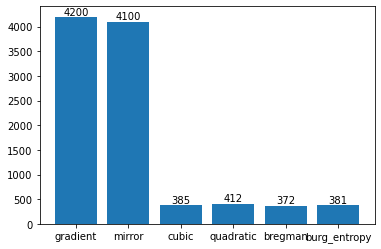

In [560]:
mtds = ['gradient', 'mirror', 'cubic', 'quadratic', 'bregman', 'burg_entropy']
speed = [GD_time, MD_time, CR_time, QR_time, BR_time, BR_BE_time]

plt.bar_label(plt.bar(mtds,speed))
plt.savefig("100d_speed")

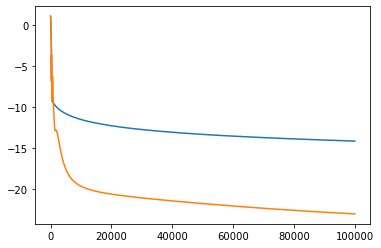

In [342]:
plt.plot(np.log(np.abs(loss_x_global[:,3]-loss_star)))
plt.plot(np.log(np.abs(DGD_loss_x_global[:,3]-loss_star)))

In [255]:
print(np.min(loss_x_global))

1.0663762857743286e-07


(0.0, 5.0)

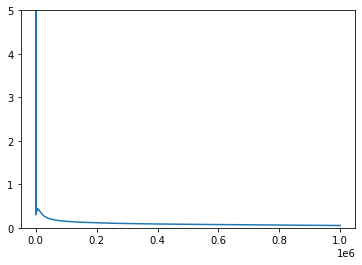

In [430]:
section_size =500000000
plt.plot(((k_range[0:section_size]+1)**2 *(loss_x_global[:section_size,3]-loss_star)))
plt.ylim(0,5)

In [227]:
print(x_k)

[[ 0.03847775 -0.29119031 -0.21288476 -0.25448257]
 [ 0.03847775 -0.2911902  -0.21288475 -0.25448286]
 [ 0.03847789 -0.29119013 -0.2128848  -0.25448306]
 [ 0.0384781  -0.29119011 -0.2128849  -0.25448309]
 [ 0.03847831 -0.29119016 -0.212885   -0.25448293]
 [ 0.03847845 -0.29119027 -0.21288508 -0.25448264]
 [ 0.03847844 -0.29119037 -0.21288509 -0.25448235]
 [ 0.03847831 -0.29119044 -0.21288504 -0.25448216]
 [ 0.03847809 -0.29119046 -0.21288494 -0.25448214]
 [ 0.03847788 -0.29119041 -0.21288483 -0.25448229]]
